# 📊 Diagnóstico Completo do Modelo de Predição de Contratação

In [3]:
import pandas as pd
import numpy as np
from sklearn.model_selection import cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from xgboost import XGBClassifier
from sklearn.metrics import classification_report, precision_recall_curve, f1_score
from imblearn.combine import SMOTETomek
from ml.data_loader import load_and_prepare_data
import shap
import matplotlib.pyplot as plt
import warnings; warnings.filterwarnings('ignore')

In [ ]:
# Carregar base
df = load_and_prepare_data()


In [7]:
if 'sap' in df.columns:
    df['vaga_sap'] = df['sap'].map({'Sim': 1, 'Não': 0}).fillna(0)
    
    
from sentence_transformers import SentenceTransformer, util

model_emb = SentenceTransformer("all-MiniLM-L6-v2")

def safe_literal_eval(x):
    import ast
    if isinstance(x, str):
        try:
            return ast.literal_eval(x)
        except:
            return []
    return x

df['keywords_exigidas'] = df['keywords_exigidas'].apply(safe_literal_eval)
df['keywords_candidato'] = df['keywords_candidato'].apply(safe_literal_eval)

def calc_match_score_semantic(row):
    exigidas = row["keywords_exigidas"]
    candidato = row["keywords_candidato"]
    if not exigidas or not candidato:
        return 0.0
    emb_exigidas = model_emb.encode(exigidas, convert_to_tensor=True)
    emb_candidato = model_emb.encode(candidato, convert_to_tensor=True)
    sim_matrix = util.pytorch_cos_sim(emb_exigidas, emb_candidato)
    return float(sim_matrix.max(dim=1).values.mean())

df["semantic_match_score"] = df.apply(calc_match_score_semantic, axis=1)

In [8]:
# Corrigir tipos
for col in ['match_score', 'semantic_match_score', 'nivel_ingles', 'nivel_espanhol', 'nivel_academico', 'vaga_sap']:
    df[col] = pd.to_numeric(df[col], errors="coerce").fillna(0)

# Criar features
df["gap_ingles"] = df["nivel_ingles"] - 1
df["gap_nivel"] = df["nivel_academico"] - 3
df["tem_sap"] = df["keywords_candidato"].astype(str).str.contains("sap", case=False).astype(int)

In [9]:
features = ['nivel_ingles', 'nivel_espanhol', 'nivel_academico', 'vaga_sap',
             'semantic_match_score', 'match_score', 'gap_ingles', 'gap_nivel', 'tem_sap']
X = df[features]
y = df['target_contratado']

In [10]:
X_res, y_res = SMOTETomek().fit_resample(X, y)
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_res)

In [11]:
models = {
    "XGBoost": XGBClassifier(use_label_encoder=False, eval_metric='logloss'),
    "RandomForest": RandomForestClassifier(class_weight='balanced'),
    "LogisticRegression": LogisticRegression(class_weight='balanced', max_iter=1000)
}
for name, model in models.items():
    score = cross_val_score(model, X_scaled, y_res, cv=5, scoring='f1')
    print(f"{name} - F1 médio: {score.mean():.4f}")

XGBoost - F1 médio: 0.5353
RandomForest - F1 médio: 0.5353
LogisticRegression - F1 médio: 0.5353


In [12]:
model = XGBClassifier(use_label_encoder=False, eval_metric='logloss')
model.fit(X_scaled, y_res)
probas = model.predict_proba(X_scaled)[:, 1]

In [13]:
best_t = 0.0
best_f1 = 0.0
for t in np.arange(0.1, 0.9, 0.01):
    preds = (probas >= t).astype(int)
    f1 = f1_score(y_res, preds)
    if f1 > best_f1:
        best_f1 = f1
        best_t = t
print(f"Melhor threshold: {best_t:.2f} | F1-score: {best_f1:.4f}")

Melhor threshold: 0.33 | F1-score: 0.6669


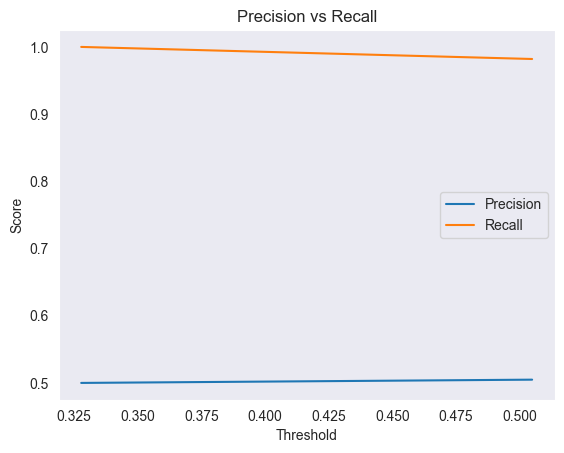

In [14]:
prec, rec, thresholds = precision_recall_curve(y_res, probas)
plt.plot(thresholds, prec[:-1], label="Precision")
plt.plot(thresholds, rec[:-1], label="Recall")
plt.xlabel("Threshold")
plt.ylabel("Score")
plt.title("Precision vs Recall")
plt.grid()
plt.legend()
plt.show()

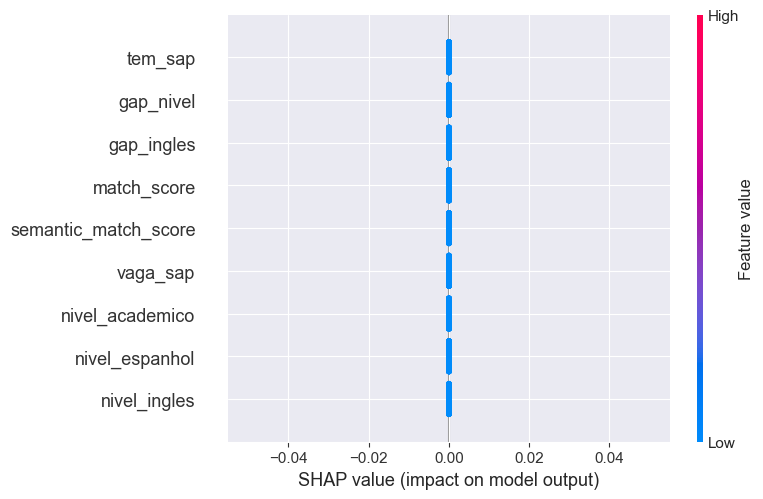

In [15]:
explainer = shap.Explainer(model, X_res, feature_names=features)
shap_values = explainer(X_res[:1000])
shap.summary_plot(shap_values, features=X_res[:1000], feature_names=features)